In [13]:
# Here we will define all the functions which assist in augmentation as well as preprocessing of the images
# which will be fed to the model.
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt 
# Here we will define the function for preprocessing and augmentation
def shadow_augmentation(image):
    # Let us randomly define the quadrilateral where we want to apply the shadow 
    pt1 = np.array([np.random.choice([0, image.shape[1]]), 0])
    pt2 = np.array([pt1[0], image.shape[0]])
    pt3 = np.array([np.random.randint(0, image.shape[0]//2), image.shape[0]])
    pt4 = np.array([np.random.randint(0, image.shape[0]//2), 0])
    pts = np.array([pt1, pt2, pt3, pt4])
    #print(pts)
    # Convert the image to Hue, Lightness, Saturation color model.
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Initialize the mask
    shadow_mask = 0*image_HLS[:, :, 1]
    # Now fill the quadrilateral as defined before
    shadow_mask = cv2.fillConvexPoly(shadow_mask, pts, 1)
    shadow_prob = np.random.random()
    # Apply shadow augmentation randomly to the images
    if shadow_prob > 0.5:
        random_shadow = 0.5
        image_HLS[:, :, 1][shadow_mask==1] = image_HLS[:, :, 1][shadow_mask==1]*random_shadow
    # Convert back to RGB Color model.
    image = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)
    return image

def read_image(row, index, col_index):
        source_path = row[col_index][index]
        filename = source_path.split('/')[-1]
        current_path = './data/IMG/' + filename
        image = cv2.cvtColor(cv2.imread(current_path), cv2.COLOR_BGR2RGB)
        return image
    
def brightness_augment(image):
    # Convert to the HSV colorspace first.
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    # Randomly assign the brightness value 
    brightness_random = .5 + np.random.uniform()
    image[:,:,2] = image[:,:,2]*brightness_random
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image
def translation_augmentation(image, steer_angle, translation_range):
    # Translation
    dx = translation_range*(np.random.uniform()-0.5)
    steer_trans = steer_angle + (dx/(translation_range))*2*.2
    (cols, rows)= image.shape[:2]
    dy = 20*(np.random.uniform()-0.5)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    image_trans = cv2.warpAffine(image, M, (cols, rows))
    return image_trans, steer_trans

def crop_image(image):
    cropped_image = image[70:135, :, :]
    return cropped_image 

def normalize_image(image):
    image.astype(np.float32)
    image = image/255. - 0.5 
    return image 

def resize_image(image, target_shape):
    return cv2.resize(image, target_shape)

def preprocess_image(image,target_shape):
    image = crop_image(image)
    image = resize_image(image, target_shape)
    image = normalize_image(image)
    return image 

def augmentation(row, index):
    col_index = 0
    cam_image = np.random.choice(['left', 'right', 'center'])
    #print(index)
    #print(row[3][index])
    steering = float(row[3][index])
    if cam_image == "left":
        steering += 0.25
        col_index = 1
    elif cam_image == "right":
        steering -= 0.25
        col_index = 2
    image = read_image(row, index, col_index)
    # Flipping Augmentation
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        image = cv2.flip(image, 1)
        steering = -1*steering
    # Brightness Augmentation
    image = brightness_augment(image)
    # Shadow Augmentation
    image = shadow_augmentation(image)
    # Preprocess the image 
    image = preprocess_image(image, (64, 64))
    # Translate the image
    image, steering = translation_augmentation(image, steering, 20)
    #plt.imshow(image, cmap = 'gray'), plt.show()
    return image, steering

In [38]:
# In this cell, we define a generator function. Which will take as input rows of data from the pandas dataframe object,
# as well as a batch size. And will infinitely return augmented images from the rows when called upon.
import csv
import sklearn
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
i = 0
def data_generator(row, batch_size = 32, plot = False):
    N = len(row)
    batches_per_epoch = N // batch_size
    i = 0

    while(True):
        start = i*batch_size
        end = start + batch_size - 1
        # Initialize the batch data 
        X_train = np.zeros((batch_size, 64, 64, 3), dtype = np.float32)
        y_train = np.zeros((batch_size,), dtype = np.float32)
        for k in range(batch_size):
                index = np.random.randint(N)
                #print(N)
                keep_steering_angle = 0
                while keep_steering_angle == 0:
                    (x, y) = augmentation(row, index)
                    
                    # If absolute value of steering angle smaller than 0.1, discard it with some probability.
                    if (abs(y) == 0.25 or abs(y) == 0.0):
                        
                        prob = np.random.uniform()
                        
                        # Set steer_prob_threshold depending on how many steering angles close to zero, we want to discard.
                        if prob > steer_prob_threshold:
                            
                            keep_steering_angle = 1
                    else:
                        # If absolute value of steering angle is greater than 0.1, then we keep it.
                        keep_steering_angle = 1
                #print(x)
                if plot:
                    print(x.dtype)
                    plt.imshow(x, cmap = 'gray'), plt.title("Steering = {:.3f}".format(y)), plt.show()
                
                (X_train[k], y_train[k]) = (x, y)
        i += 1 
        if i == batches_per_epoch - 1:
            i = 0 
        (X_train, y_train) = sklearn.utils.shuffle(X_train, y_train)
        yield (X_train, y_train)

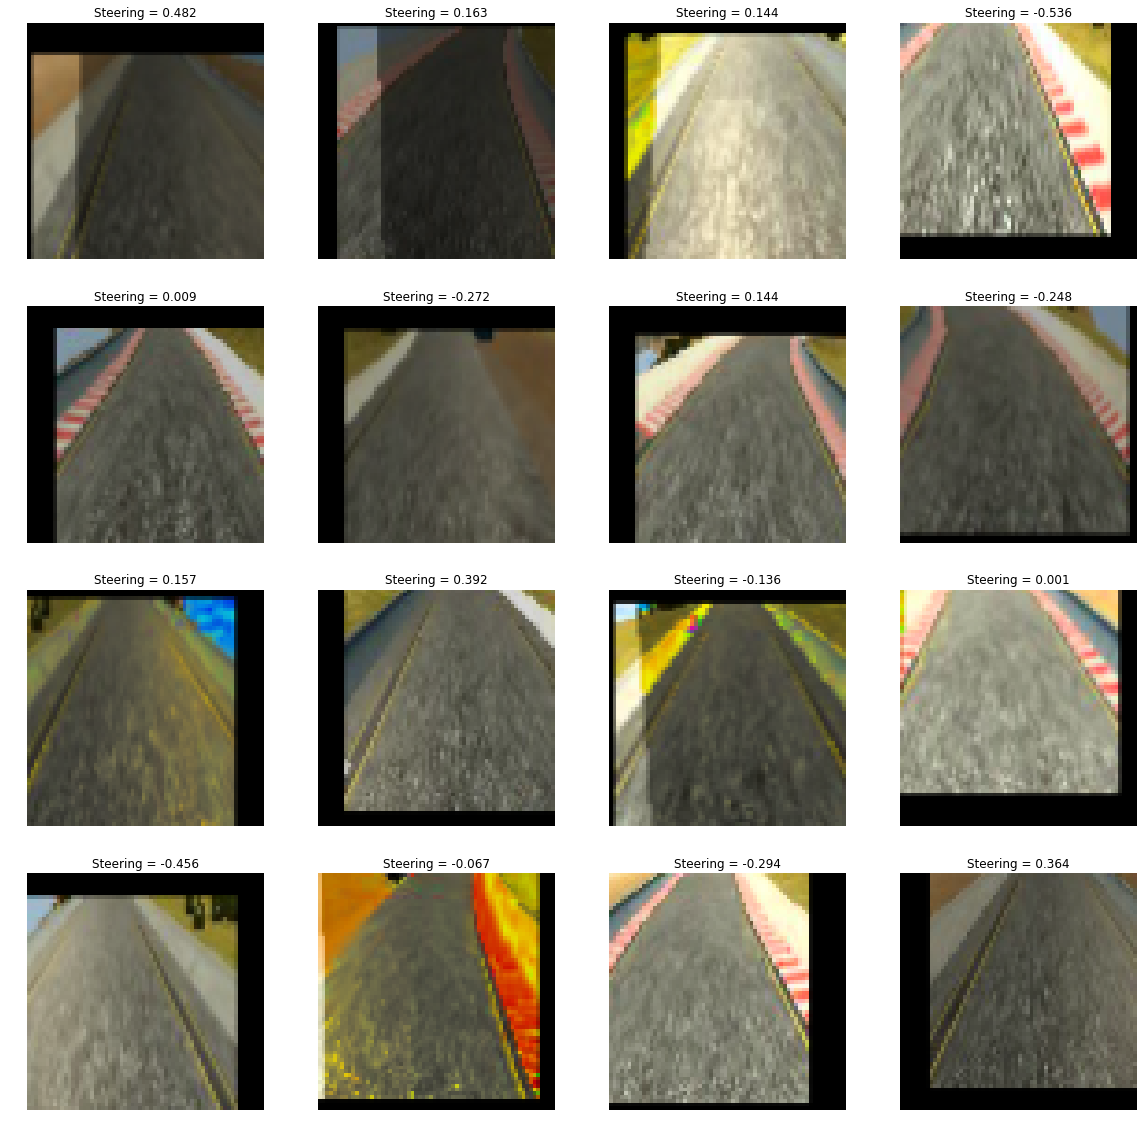

In [66]:
# Plot augmented images
import pandas as pd
from keras.callbacks import History, Callback
from random import shuffle   
figures = {}
labels = {}
def plot_images(figures, num_rows, num_cols, labels = None):
    fig, axes = plt.subplots(nrows = num_rows, ncols= num_cols, figsize = (20, 20))
    axes = axes.ravel()
    for fignumber, heading in zip(range(len(figures)), figures):
        img = figures[heading]
        axes[fignumber].imshow(figures[heading], cmap = "gray")
        axes[fignumber].axis("off")
        if labels!=None:
            axes[fignumber].set_title(labels[fignumber])
        else:
            axes[fignumber].set_title(heading)
    fig.savefig("Augmented_Images.jpeg")
    return img

image_dataframe = pd.read_csv('./data/driving_log.csv', header=None, usecols = [0,1,2,3], skiprows = 1)
(nrows, ncols) = image_dataframe.shape
# Let us shuffle the rows of the dataframe before splitting into training and validation sets.
image_dataframe = image_dataframe.sample(frac = 1).reset_index(drop = "True")
training_lines = image_dataframe.loc[0:50]
# Let us just plot few images, to see how they look with augmentation and preprocessing.
for i in range(1):
    x_batch, y_batch = next(data_generator(training_lines, 16, plot = False))
for i in range(len(x_batch)):
    image = x_batch[i].squeeze().astype(np.uint8)
    figures[i] = image
    labels[i] = "Steering = {:.3f}".format(y_batch[i])
a = plot_images(figures, 4, 4, labels = labels)
    

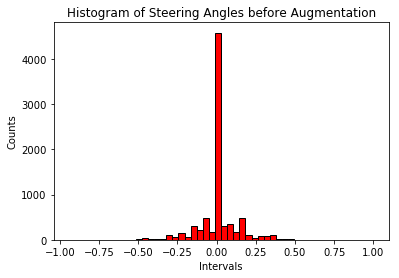

In [59]:
# LOAD AND VISUALIZE THE ORIGINAL DATA
# images = []
# measurements = []
# i = 0
# lines = []
# with open('./data/driving_log.csv') as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.append(line)
# for line in lines:
#     if line[3] == "steering":
#         continue
#     source_path = line[0]
#     measurement = float(line[3])
#     measurements.append(measurement)
#     filename = source_path.split('/')[-1]
#     current_path = './data/IMG/' + filename
#     image = cv2.imread(current_path)
#     image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = shadow_augmentation(image)
#     #plt.imshow(image, cmap = 'gray'), plt.show()
#     images.append(image)
        
#     i +=1
#     if i == 100000:
#         break

# X_train = np.array(images)
# y_train = np.array(measurements)
fig = plt.figure()
values_wo = plt.hist(y_train, bins = 50, ec = "black", color = "r"), plt.title("Histogram of Steering Angles before Augmentation")
plt.xlabel("Intervals"), plt.ylabel("Counts"), plt.show()
fig.savefig("HistNoAug.jpeg")

In [ ]:
# A function for dropping rows with steering angles in an interval close to zero
def drop_rows(lines, percent_drop):
    indices = []
    for i in range(len(lines)):
        if abs(float(lines[3][i])) <= 0.01:
            indices.append(i)
    print("The number of samples with steering angles less than 0.01 is: %d" %(len(indices)))
    shuffle(indices)
    num = int(percent_drop*len(indices))
    new_indices = indices[0:num-1]
    print("The number of samples being dropped is: %d" %(len(new_indices)))
    new_lines = lines.drop(lines.index[new_indices])
    new_lines = new_lines.sample(frac=1).reset_index(drop = "True")
    return new_lines   

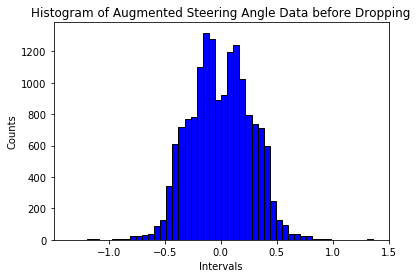

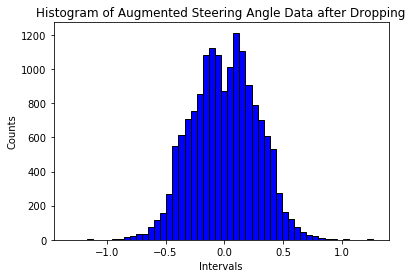

In [64]:
# HISTOGRAM VISUALIZATION OF AUGMENTED AND FILTERED DATA
# import pandas as pd
# from keras.callbacks import History, Callback
# from random import shuffle       
# batch_size = 32
# image_dataframe = pd.read_csv('./data/driving_log.csv', header=None, usecols = [0,1,2,3], skiprows = 1)
# (nrows, ncols) = image_dataframe.shape
# # Let us shuffle the rows of the dataframe before splitting into training and validation sets.
# image_dataframe = image_dataframe.sample(frac = 1).reset_index(drop = "True")
# # Let us take 80% of the data for training
# num_training_lines = int(0.8*nrows)
# training_old_lines = image_dataframe.loc[0:num_training_lines-1]
# validation_old_lines = image_dataframe.loc[num_training_lines:]
# validation_old_lines = validation_old_lines.sample(frac=1).reset_index(drop = "True")
# anglesold = np.array([], dtype = np.float32)
# for i in range(500):
#     x_batch, y_batch = next(data_generator(training_old_lines, 32))
#     anglesold = np.concatenate((anglesold, y_batch))
fig1 = plt.figure()
plt.xlabel("Intervals"), plt.ylabel("Counts"), plt.title("Histogram of Augmented Steering Angle Data before Dropping")
valuesold = plt.hist(anglesold, bins = 50, ec = "black", color = "b"), plt.show()
fig1.savefig("HistAugNoDrop.jpeg")

# training_lines = drop_rows(training_old_lines, 0.40)
# validation_lines = drop_rows(validation_old_lines, 0.40)
# steer_prob_threshold = 0.0
# angles = np.array([], dtype = np.float32)
# for i in range(500):
#     x_batch, y_batch = next(data_generator(training_lines, 32))
#     angles = np.concatenate((angles, y_batch))
fig2 = plt.figure()
plt.xlabel("Intervals"), plt.ylabel("Counts")
plt.title("Histogram of Augmented Steering Angle Data after Dropping")
values = plt.hist(angles, bins = 50, ec = "black", color = "b"), plt.show()
fig2.savefig("HistAugDrop(40%).jpeg")

In [3]:
from keras.layers import Dense, Flatten, Activation, Convolution2D, Cropping2D, Lambda, Dropout, Conv2D, ELU, MaxPooling2D
from keras.models import Sequential
from keras import optimizers
def get_model():
    model = Sequential()
    
    #Layer 1
    # Output of layer 1 is : 64x64x3
    model.add(Convolution2D(filters = 3, kernel_size = (1,1), strides=(1, 1), input_shape = (64, 64, 3), activation = 'elu', padding = "same"))
    
    #Layer 2
    # Output of layer 2 is 64x64x32
    model.add(Convolution2D(32, (3,3) ,strides=(1, 1), activation='elu', padding = "same"))
    # Output of MaxPooling is 32x32x32
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    # Layer 3
    # Output of layer 3 is 32x32x64
    model.add(Convolution2D(64, (3, 3), strides = (1, 1), activation = "elu", padding = "same"))
    # Output of MaxPooling is 16x16x64
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    # Layer 4
    # Output of layer 4 is 16x16x128
    model.add(Convolution2D(128, (3, 3), strides = (1, 1), activation = "elu", padding = "same"))
    # Output of MaxPooling is 8x8x128
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    # Flatten Layer
    # Output of flatten layer is 8192x1
    model.add(Flatten())
    
    #Layer 5
    # Output of layer 5 is 512x1
    model.add(Dense(512, activation = "elu"))

    #Layer 4
    # Output of layer 4 is 200x1
    model.add(Dense(200, activation = "elu"))

    #Layer 5
    # Output of layer 5 is 100x1
    model.add(Dense(100, activation = "elu"))

    #Layer 6
    # Output of layer 6 is 1x1
    model.add(Dense(1))

    model.compile(loss='mse',optimizer= "adam")
    return model


In [4]:
# LOADING THE DATA
# Import required packages
import pandas as pd
from keras.models import load_model
from keras.callbacks import History, Callback
from random import shuffle
# Define a Callback class incase we want details about the loss and accuracy for later use.
class LossHistory(Callback):
    def on_train_begin(self, logs = {}):
        self.training_loss = []
        self.training_acc = []
        self.validation_loss = []
        self.validation_acc = []
    def on_epoch_end(self, epoch, logs = {}):
        self.training_loss.append(logs.get('loss'))
        self.validation_loss.append(logs.get('val_loss'))
        self.training_acc.append(logs.get('acc'))
        self.validation_acc.append(logs.get('val_acc'))      
history = LossHistory()
# Define batch size and number of epochs
batch_size = 32
nb_epochs = 3
# Load the data
image_dataframe = pd.read_csv('./data/driving_log.csv', header=None, usecols = [0,1,2,3], skiprows = 1)
(nrows, ncols) = image_dataframe.shape
# Let us shuffle the rows of the dataframe before splitting into training and validation sets.
image_dataframe = image_dataframe.sample(frac = 1).reset_index(drop = "True")
# Let us take 80% of the data for training
num_training_lines = int(0.8*nrows)
training_old_lines = image_dataframe.loc[0:num_training_lines-1]
validation_old_lines = image_dataframe.loc[num_training_lines:]
validation_old_lines = validation_old_lines.sample(frac=1).reset_index(drop = "True")
training_lines = drop_rows(training_old_lines, 0.40)
validation_lines = drop_rows(validation_old_lines, 0.40)
steer_prob_threshold = 0.3
validation_lines = validation_lines.sample(frac=1).reset_index(drop = "True")
training_generator = data_generator(training_lines, batch_size)
validation_generator = data_generator(validation_lines, batch_size)




3542
1415
910
363
Epoch 1/3
625/625 [==============================] - 121s - loss: 0.0309 - val_loss: 0.0287
Epoch 2/3
625/625 [==============================] - 119s - loss: 0.0281 - val_loss: 0.0271
Epoch 3/3
625/625 [==============================] - 119s - loss: 0.0271 - val_loss: 0.0329


In [70]:
# FITTING THE MODEL
# Load the previous model
from keras.models import load_model
model = load_model("Track1Bridge.h5")
model.summary()
# # Define steps per epoch and validation steps parameters
steps_per_epoch = 20000 // batch_size
v_steps = 2000 // batch_size
# Fit the model with the new data
model.fit_generator(training_generator, steps_per_epoch = steps_per_epoch, epochs = nb_epochs, verbose = 1, callbacks = [history], validation_data = validation_generator, validation_steps = v_steps)
model.save("NewModel.h5")
# #model.save_weights("Generator_Model_Weights.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
__________

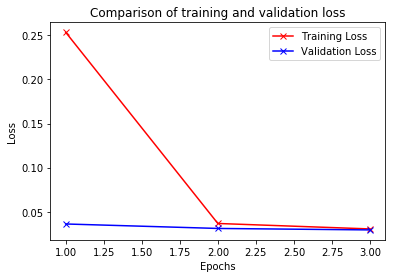

(<matplotlib.legend.Legend at 0x7f3fa4ccfa58>, None)

In [5]:
# Plot the loss vs epochs.
plt.figure(1)
plt.title("Comparison of training and validation loss")
plt.plot(range(1, nb_epochs+1), history.training_loss, 'r-x', label = "Training Loss")
plt.plot(range(1, nb_epochs+1), history.validation_loss, 'b-x', label = "Validation Loss")
plt.ylabel("Loss"), plt.xlabel("Epochs")
plt.legend(loc = "upper right"), plt.show()
